### Assignment 2: State prediction

In this assignment you are learning to estimate state from the acquired range-rate data.
You will capture the data and look at differnt arc settings.

In this estimation you are using a full SH model of the gravity field of Earth

In [1]:
# Load standard modules
import statistics
# Uncomment the following to make plots interactive
# %matplotlib widget
from matplotlib import pyplot as plt

from propagation_functions.environment import *
from propagation_functions.propagation import *
from estimation_functions.estimation import *
from estimation_functions.observations_data import *

from utility_functions.time import *
from utility_functions.tle import *

# Load tudatpy modules
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation_setup
from tudatpy.kernel.astro import element_conversion

In [2]:
# Start of time
j2000_days = 2451545.0

# Define import folder
metadata_folder = 'metadata/'
data_folder = 'data/'

# Files to be uploaded
metadata = ['Delfi-C3_32789_202004011044.yml', 'Delfi-C3_32789_202004011219.yml', 'Delfi-C3_32789_202004020904.yml', 'Delfi-C3_32789_202004021953.yml',
            'Delfi-C3_32789_202004031031.yml', 'Delfi-C3_32789_202004031947.yml', 'Delfi-C3_32789_202004041200.yml', 'Delfi-C3_32789_202004061012.yml',
            'Delfi-C3_32789_202004062101.yml', 'Delfi-C3_32789_202004062236.yml', 'Delfi-C3_32789_202004072055.yml', 'Delfi-C3_32789_202004072230.yml',
            'Delfi-C3_32789_202004081135.yml']

data = ['Delfi-C3_32789_202004011044.DOP1C', 'Delfi-C3_32789_202004011219.DOP1C', 'Delfi-C3_32789_202004020904.DOP1C', 'Delfi-C3_32789_202004021953.DOP1C',
        'Delfi-C3_32789_202004031031.DOP1C', 'Delfi-C3_32789_202004031947.DOP1C', 'Delfi-C3_32789_202004041200.DOP1C', 'Delfi-C3_32789_202004061012.DOP1C',
        'Delfi-C3_32789_202004062101.DOP1C', 'Delfi-C3_32789_202004062236.DOP1C', 'Delfi-C3_32789_202004072055.DOP1C', 'Delfi-C3_32789_202004072230.DOP1C',
        'Delfi-C3_32789_202004081135.DOP1C']

# Specify which metadata and data files should be loaded (this will change throughout the assignment)
# 1. & 2. only one pass
# 3. & 4. all passes
indices_files_to_load = [0, 1]
# indices_files_to_load = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [3]:
# Retrieve initial epoch and state of the first pass
initial_epoch, initial_state_teme = get_tle_initial_conditions(metadata_folder + metadata[0])
start_recording_day = get_start_next_day(initial_epoch)

# Calculate final propagation_functions epoch
nb_days_to_propagate = 9
final_epoch = start_recording_day + nb_days_to_propagate * 86400.0

print('initial_epoch', initial_epoch)
print('final_epoch', final_epoch)

# Load and process observations
passes_start_times, passes_end_times, observation_times, observations_set = load_and_format_observations(data_folder, data, indices_files_to_load)


initial_epoch 638874855.9999838
final_epoch 639662400.0


In [4]:
# Define tracking arcs and retrieve the corresponding arc starting times (this will change throughout the assignment)
# Three options: one arc per pass ('per_pass'), one arc per day ('per_day') and one arc per week ('per_week')
arc_start_times, arc_end_times = define_arcs('per_week', passes_start_times, passes_end_times)

print('arc_start_times', arc_start_times)
print('arc_end_times', arc_end_times)


arc_start_times [638971200.0]
arc_end_times [639057600.0]


In [5]:
# Define propagation_functions environment
mass_delfi = 2.2
reference_area_delfi = 0.035
drag_coefficient_delfi = 1.4
srp_coefficient_delfi = 2.4
bodies = define_environment(mass_delfi, reference_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi, multi_arc_ephemeris=False)

# Set Delfi's initial state of Delfi
initial_state = element_conversion.teme_state_to_j2000(initial_epoch, initial_state_teme)


# Define accelerations exerted on Delfi
# Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
acceleration_models = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Venus={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Jupiter={
        'point_mass_gravity': True
    }
)
accelerations = create_accelerations(acceleration_models, bodies)

# Propagate dynamics and retrieve Delfi's initial state at the start of each arc
orbit = propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations)
arc_wise_initial_states = get_initial_states(bodies, arc_start_times)


===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




Warning when processing deprecated propagator settitngs, integrator settings defined independently, and in propagator settings


In [6]:
# Redefine environment to allow for multi-arc dynamics propagation_functions
bodies = define_environment(mass_delfi, reference_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi, multi_arc_ephemeris=True)
accelerations = create_accelerations(acceleration_models, bodies)

# Define multi-arc propagator settings
multi_arc_propagator_settings = define_multi_arc_propagation_settings(arc_wise_initial_states, arc_start_times, arc_end_times, bodies, accelerations)

# Create the DopTrack station
define_doptrack_station(bodies)


# Define default observation settings
# Specify on which time interval the observation bias(es) should be defined. This will change throughout the assignment (can be 'per_pass', 'per_arc', 'global')
# Noting that the arc duration can vary (see arc definition line 64)
bias_definition = 'per_pass'
Doppler_models = dict(
    absolute_bias={
        'activated': True,
        'time_interval': bias_definition
    },
    relative_bias={
        'activated': True,
        'time_interval': bias_definition
    },
    time_bias={
        'activated': True,
        'time_interval': bias_definition
    }
)
observation_settings = define_observation_settings(Doppler_models, passes_start_times, arc_start_times)

# Define parameters to estimate
parameters_list = dict(
    initial_state_delfi={
        'estimate': True,
        'type': 'per_arc' # Do not modify this entry. To modify the frequency at which Delfi's initial state is estimated,
                          # the tracking arc duration should be directly modified (go to line 64 and change the arc definition)
    },
    absolute_bias={
        'estimate': True,
        'type': bias_definition # Do not modify this entry, it should be consistent with the bias definition above
    },
    relative_bias={
        'estimate': True,
        'type': bias_definition # Idem
    },
    time_bias={
        'estimate': True,
        'type': bias_definition # Idem
    }
)
parameters_to_estimate = define_parameters(parameters_list, bodies, multi_arc_propagator_settings, initial_epoch,
                                           arc_start_times, passes_start_times, Doppler_models)
estimation_setup.print_parameter_names(parameters_to_estimate)

# Create the estimator object
estimator = numerical_simulation.Estimator(bodies, parameters_to_estimate, observation_settings, multi_arc_propagator_settings)

print('max observation_times', max(observation_times))
# Simulate (ideal) observations
ideal_observations = simulate_observations_from_estimator(observation_times, estimator, bodies)


Parameter start index, Parameter definition
0, arc-wise translational state of (Delfi).
6, absolute arc-wise observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))
8, relative arc-wise observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))
10, arc-wise time drift observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))

---------------  STARTING PROPAGATION FOR ARC 0  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

max observation_times 639008987.3395922


# Run the estimation

Now you are all setup to run the estimation. In the following block the dynamic equations are set and the estimator knows what kind of parameters need to be estimated.

Press run. This can take a while, depending on your amount of data and settings

In [7]:
# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector
nb_parameters = len(truth_parameters)

# Perform estimation_functions
nb_iterations = 10
nb_arcs = len(arc_start_times)
pod_output = run_estimation(estimator, parameters_to_estimate, observations_set, nb_arcs, nb_iterations)

print(pod_output.formal_errors)

residuals = pod_output.residual_history
mean_residuals = statistics.mean(residuals[:,nb_iterations-1])
std_residuals = statistics.stdev(residuals[:,nb_iterations-1])

print('mean', mean_residuals)
print('standard deviation', std_residuals)


---------------  STARTING PROPAGATION FOR ARC 0  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

[1.45874306e+03 1.57704456e+03 7.29474704e+02 1.60431815e+00
 1.09033134e+00 1.23217919e+00 1.57901267e+00 8.08773304e+00
 1.98335258e-04 1.59638394e-03 4.66912408e-03 2.70409992e-02]
mean -0.14653911760124652
standard deviation 4.644772794345585
-----------------------------------------------------------------

Calculating residuals and partials 2178
Parameter update      5718.1      8285.38      16720.5      -6.1502      25.1676     -12.3417      406.265      398.272 -0.000662945   -0.0143148     -1.26173     -1.37877
Current residual: 215.187
---------------  STARTING PROPAGATION FOR ARC 0  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body

Warning when performing least squares, condition number is 2.91616e+08
Warning when performing least squares, condition number is 2.9029e+08
Warning when performing least squares, condition number is 2.91086e+08
Warning when performing least squares, condition number is 2.91348e+08
Warning when performing least squares, condition number is 2.91479e+08
Warning when performing least squares, condition number is 2.91533e+08
Warning when performing least squares, condition number is 2.9154e+08
Warning when performing least squares, condition number is 2.9152e+08
Warning when performing least squares, condition number is 2.91483e+08
Warning when performing least squares, condition number is 2.91438e+08


69703     0.048769
Current residual: 5.01692
---------------  STARTING PROPAGATION FOR ARC 0  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

Calculating residuals and partials 2178
Parameter update     2245.88      38.2315     -1376.61       2.5379       2.1631      -1.3077    -0.154315     -10.0056 -3.95824e-05   0.00212333 -0.000636422    0.0318263
Current residual: 4.79404
---------------  STARTING PROPAGATION FOR ARC 0  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

Calculating residuals and partial

# Inspect the results

The first number that we look at is final residual. This shows the difference (RMS???) between the observed range-rate and the final orbit model estimated by your program.

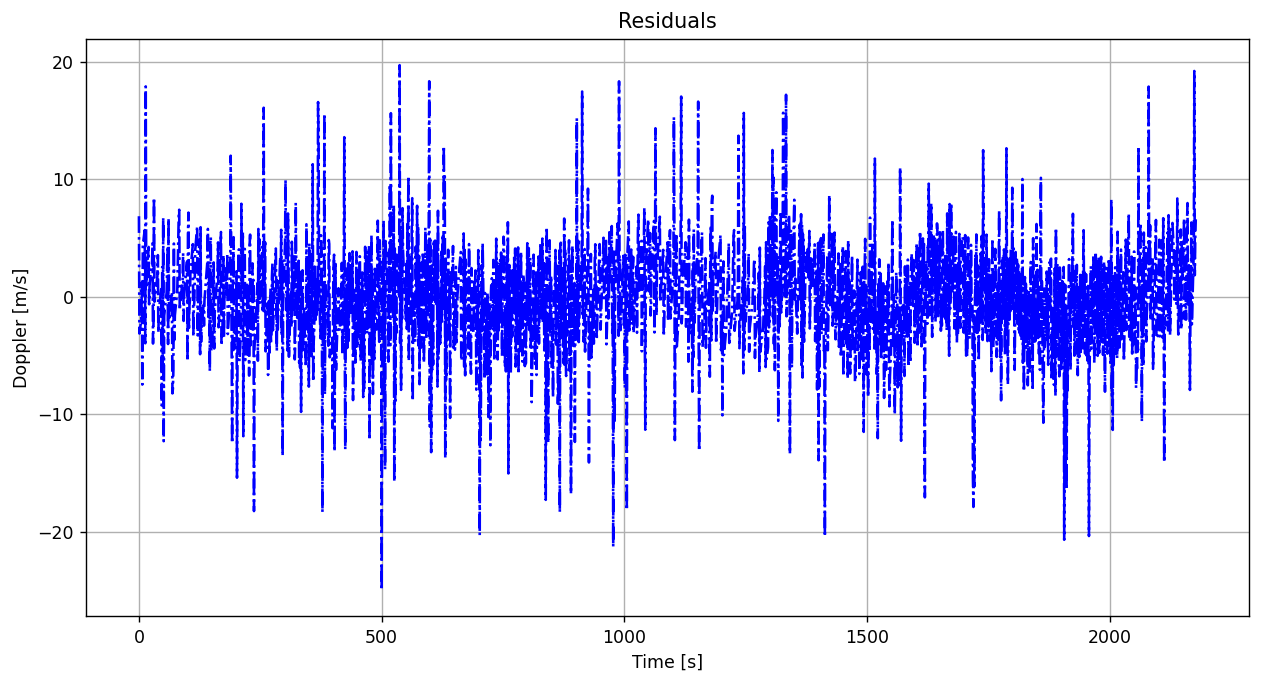

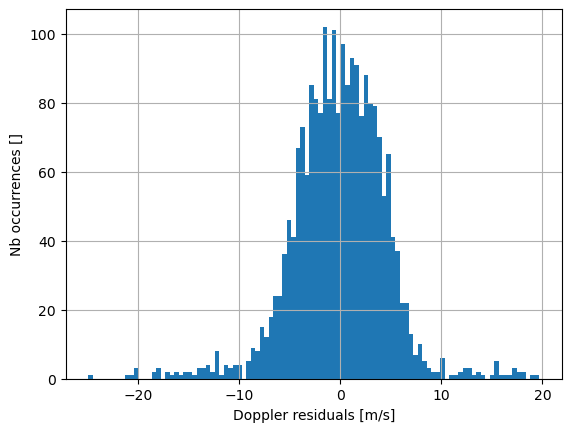

In [9]:
# Plot residuals
fig = plt.figure(figsize=(12,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Residuals')

# ax.plot(residuals[:,0], color='red', linestyle='-.')
# ax.plot(residuals[:,1], color='green', linestyle='-.')
# ax.plot(residuals[:,2], color='green', linestyle='-.')
ax.plot(residuals[:,nb_iterations-1],color='blue', linestyle='-.')

# ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

# Plot residuals histogram
fig = plt.figure()
ax = fig.add_subplot()
# plt.hist(residuals[:,1],100)
plt.hist(residuals[:,nb_iterations-1],100)
ax.set_xlabel('Doppler residuals [m/s]')
ax.set_ylabel('Nb occurrences []')
plt.grid()
plt.show()